In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric   
!pip3 install pickle5
import matplotlib.pyplot as plt
#!pip3 install "git+https://github.com/tqdm/tqdm.git@devel#egg=tqdm"
from tqdm.notebook import tqdm
from torch.nn import Linear
import torch.nn.functional as F
import json
from torch_geometric import data
import torch_geometric.datasets  as d
from torch_geometric.nn import SAGEConv, to_hetero, ResGatedGraphConv, GENConv, to_hetero_with_bases
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.nn as nn
#!pip3 install torch_bincount
import pickle5 as pickle
import pandas as pd
#from torch_bincount import bincount

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 11.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 12.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.5 MB 5.5 MB/s 
     |████████████████████████████████| 407 kB 12.6 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=f37ab53f499abfd1d2ab5ada0db7ab295640bccb06b9d606c46e22ae7f208858
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 256 kB 11.6 MB/s 


In [ ]:
from torch_geometric.nn import GENConv

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GENConv(32, 128,t=1.0, learn_t=True, num_layers=2, norm='layer') # if you defined cache=True, the shape of batch must be same!
       
        
        self.fc1 = Linear(128, 64)
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, data):
      drugs=[]
      for i in data:
              edge_encoder = nn.Linear(i.edge_attr.shape[1], i.x.shape[1], dtype=torch.float32)

              i.edge_attr = edge_encoder(i.edge_attr.float())

              i.x =  self.conv1(i.x ,i.edge_index, i.edge_attr).relu()
              
              i.x = F.relu(self.fc1(i.x))
              i.x = F.relu(self.fc2(i.x))
              i.x = self.fc3(i.x)
              l=Linear(i.x.shape[0],32)
              i.x=l(i.x.T)
              drugs.append(i.x.T)
      return torch.stack(drugs,dim=0)

In [ ]:
network_path = '/content/drive/MyDrive/thesis_data/'
#network_path = '/home/gm/Downloads/thesis_data-20211116T221419Z-001/thesis_data/'
#network_path='C:\\Users\\gmixo\\Desktop\\GraphDTA-6162245c6776684b391d30610850fe7077478435\\data1\\'


with open(network_path+'v.pickle', 'rb') as handle:
        pr = pickle.load(handle)


with open(network_path+'drugs_smiles.txt') as f:
    data1 = f.read()
drug_dict = json.loads(data1, object_pairs_hook=OrderedDict)
dti_orig = np.loadtxt(network_path + 'mat_drug_protein.txt')
drug_drug = np.loadtxt('https://raw.githubusercontent.com/shulijiuba/GADTI/main/data/mat_drug_drug.txt')
protein_protein = np.loadtxt(network_path + 'mat_protein_protein.txt')
simdrugs = np.loadtxt('https://raw.githubusercontent.com/luoyunan/DTINet/master/data/Similarity_Matrix_Drugs.txt')
simproteins = np.loadtxt(network_path + 'Similarity_Matrix_Proteins.txt')

#drug_se = np.loadtxt(network_path + 'mat_drug_se.txt')

#drug_disease= np.loadtxt(network_path+'mat_drug_disease.txt')
#protein_disease=np.loadtxt(network_path+'mat_protein_disease.txt')

more_dtinteractions= pd.read_csv('https://raw.githubusercontent.com/shulijiuba/GADTI/f53b7a351cd6073c5e1e0fc39a7ad26911eb9c9e/data/DTI_newly.csv', index_col=False,header=None)
more_dtinteractions= more_dtinteractions.to_numpy().tolist()


script_dir = os.path.dirname(network_path) #<-- absolute dir the script is in
rel_path = "drug.txt"
abs_file_path = os.path.join(script_dir, rel_path)

file1 = open(abs_file_path, 'r')
drugss=[]
for i in range(708):
    line = file1.readline()
    if not line:
        break
    drugss.append(line.strip())

file1.close()
script_dir = os.path.dirname(network_path) #<-- absolute dir the script is in
rel_path = "protein.txt"

abs_file_path = os.path.join(script_dir, rel_path)

file1 = open(abs_file_path, 'r')
proteinss=[]
for i in range(1512):
    line = file1.readline()
    if not line:
        break
    proteinss.append(line.strip())

file1.close()
drugs = len(drug_drug)
proteins = len(proteinss)

dr_pr_matrix= pd.DataFrame(dti_orig,index=drugss,columns=proteinss)

prot_features = []
l1=nn.Linear(300,32)
prot_features=[]
for col in dr_pr_matrix.columns:
        
        pr_name=col
        target_features= pr[pr_name]
        prot_features.append(target_features)


with open(network_path+"drug_featuress.pickle", "rb") as d:
    drug_featuress=pickle.load(d)




dti=pd.DataFrame(dti_orig).stack().reset_index(level=0, name='Interaction').reset_index(level=0) \
      .rename(columns={'index': 'Protein', 'level_0': 'Drug'})


dti=dti[['Drug','Protein','Interaction']]
print("Drug_Protein interaction positive values: "+str(dti['Interaction'].value_counts()[1])+ \
      " and negative values: "+str(+dti['Interaction'].value_counts()[0]))
list_drug_protein=dti.loc[dti.Interaction==1].drop(["Interaction"], axis=1).to_numpy().tolist()
list_drug_protein.extend(more_dtinteractions)

ddi=pd.DataFrame(drug_drug).stack().reset_index(level=0, name='Interaction').reset_index(level=0)
print("Drug_Drug interaction positive values: "+str(ddi['Interaction'].value_counts()[1])+ \
      " and negative values: "+str(ddi['Interaction'].value_counts()[0]))
list_drug_dr=ddi.loc[ddi.Interaction==1].drop(["Interaction"], axis=1).to_numpy().tolist()

ppi=pd.DataFrame(protein_protein).stack().reset_index(level=0, name='Interaction').reset_index(level=0)
print("Protein_Protein interaction positive values: "+str(ppi['Interaction'].value_counts()[1])+ \
      " and negative values: "+str(ppi['Interaction'].value_counts()[0]))
list_prot_pr=ppi.loc[ppi.Interaction==1].drop(["Interaction"], axis=1).to_numpy().tolist()


sdi=pd.DataFrame(simdrugs).stack().reset_index(level=0, name='Similarity').reset_index(level=0)
d_dr=sdi.drop(["Similarity"], axis=1).to_numpy().tolist()

spi=pd.DataFrame(simproteins).stack().reset_index(level=0, name='Similarity').reset_index(level=0)
s_pr=spi.drop(["Similarity"], axis=1).to_numpy().tolist()

ter=torch.stack(drug_featuress,dim=0).squeeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch_geometric import data
data1= data.HeteroData().to(device)

data1['drugs'].x=torch.FloatTensor(ter.squeeze(2)).to(device)
data1['proteins'].x=torch.FloatTensor(prot_features).to(device)

  
#data1['disease'].x=torch.randint(100,(5603,1), dtype=torch.float).to(device)

#data1['side_effect'].x=torch.randint(100,(4192,1), dtype=torch.float).to(device)
data1['drugs' , 'interaction' , 'proteins'].edge_index =torch.LongTensor(list_drug_protein).t().contiguous().to(device)
#data1['drugs' , 'interact' , 'drugs'].edge_index =torch.LongTensor(list_drug_dr).t().contiguous().to(device)
#data1['proteins' , 'interact' , 'proteins'].edge_index =torch.LongTensor(list_prot_pr).t().contiguous().to(device)
#data1['drugs' , 'interact' , 'drugs'].edge_attr =torch.LongTensor(d_dr).t().contiguous().to(device)
#data1['proteins' , 'interact' , 'proteins'].edge_attr =torch.LongTensor(s_pr).t().contiguous().to(device)
#data1['side_effect' , 'interact' ,'drugs' ].edge_index =torch.LongTensor(list_se_drug).t().contiguous().to(device)
#data1['disease' , 'interact' , 'proteins'].edge_index =torch.LongTensor(list_di_pr).t().contiguous().to(device)
#data1['disease' , 'interact' , 'drugs'].edge_index =torch.LongTensor(list_di_drug).t().contiguous().to(device)

import torch_geometric.transforms as T

#data1['drugs' , 'interaction' , 'proteins'].edge_label = torch.LongTensor(edge_feat).t().contiguous().to(device)
# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data1 = T.ToUndirected()(data1).to(device)
del data1['proteins', 'rev_interaction', 'drugs'].edge_label  # Remove "reverse" label.
#del data1['drugs' , 'rev_interact' , 'drugs'].edge_label
#del data1['proteins' , 'rev_interact' , 'proteins'].edge_label
#del data1['drugs' , 'rev_interact' ,'side_effect' ].edge_label 
#del data1['proteins', 'rev_interact', 'disease'].edge_label 
#del data1['drugs', 'rev_interact', 'disease'].edge_label 
print(data1)
tfs = T.RandomLinkSplit(  is_undirected=True,
                            num_val=0.05,
                            num_test=0.15,
                            disjoint_train_ratio=1,
                            neg_sampling_ratio=10.0,
                            edge_types=[('drugs' , 'interaction' , 'proteins')],
                            rev_edge_types=[('proteins', 'rev_interaction', 'drugs')]
, )


Drug_Protein interaction positive values: 1923 and negative values: 1068573
Drug_Drug interaction positive values: 10036 and negative values: 491228
Protein_Protein interaction positive values: 7363 and negative values: 2278781
HeteroData(
  drugs={ x=[708, 32] },
  proteins={ x=[1512, 300] },
  (drugs, interaction, proteins)={ edge_index=[2, 2963] },
  (proteins, rev_interaction, drugs)={ edge_index=[2, 2963] }
)


0.5065673 0.25661045 0.09740363217556926 -0.024533503025108767 0.5070483088493347 0.5978086194302411
0.9523809552192688
0.5063369 0.2563771 0.12589382944572935 -0.02757402659971394 0.5059579610824585 0.6264172956740524
0.9523809552192688
Epoch: 1Training Loss: 0.934 Loss with  Testset :0.933
0.5046994 0.25472152 0.1851982934234437 0.060401576746819056 0.506399929523468 0.6859683162892621
0.9523809552192688
0.50447446 0.2544945 0.1983529735971833 0.05972852489971487 0.5045129060745239 0.6991777250223197
0.9523809552192688
Epoch: 2Training Loss: 0.933 Loss with  Testset :0.932
0.5032675 0.2532782 0.192172582858613 0.1044132969227804 0.5056448578834534 0.6929716033601169
0.9523809552192688
0.5030408 0.25305006 0.20671898721351004 0.10482353353140275 0.5030815005302429 0.7075785244704162
0.9523809552192688
Epoch: 3Training Loss: 0.931 Loss with  Testset :0.931
0.502259 0.25226414 0.1935206122940573 0.12225162603008502 0.5047282576560974 0.6943252373995618
0.9523809552192688
0.502042 0.2520

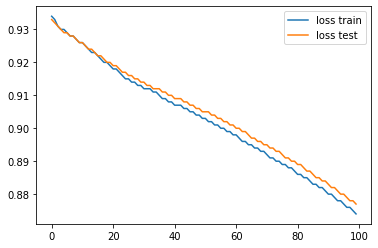

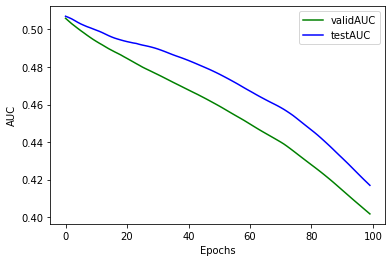

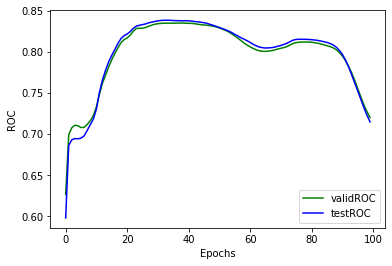

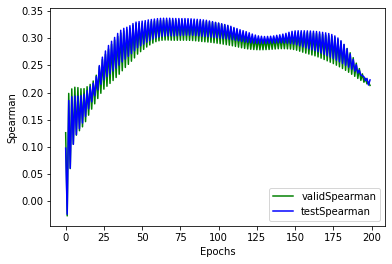

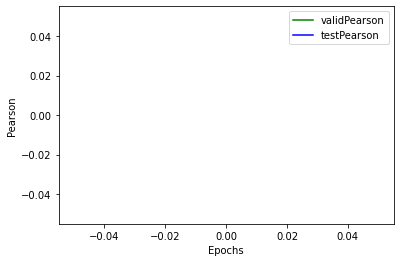

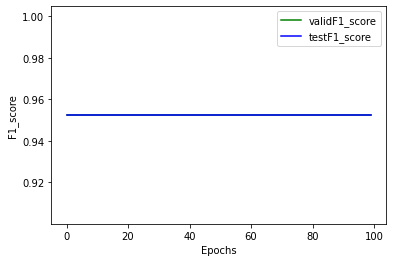

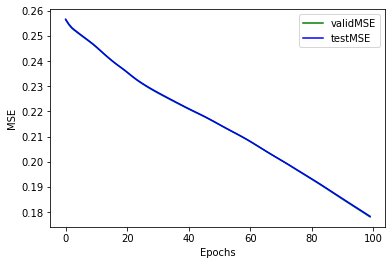

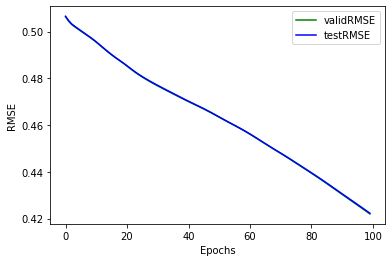

In [ ]:
from torch_geometric.utils.metric import mean_iou
import sys
import matplotlib.pyplot as plt


def plot_something(val_loss,test_loss):

  plt.plot(val_loss,label='loss train')
  plt.plot(test_loss,label='loss test')
  plt.legend()
  plt.show()

def plot_metrics(testd, vald, label):
  plt.plot(vald,'g',label='valid'+label)
  plt.plot(testd,'b',label='test'+label)
  plt.xlabel('Epochs')
  plt.ylabel(label)
  plt.legend()
  plt.show()
from torch import nn
train_data, val_data, test_data = tfs(data1)

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,aggr='add')
        self.conv2 = SAGEConv((-1, -1), out_channels, normalize=True)

    def forward(self, x, edge_index):
        x =  self.conv1(x, edge_index)
        x = self.conv2(x, edge_index).relu() 
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
       
        z = torch.cat([z_dict['drugs'][row], z_dict['proteins'][col]], dim=-1)
        
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data1.metadata())
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self,  x_dict, edge_index_dict, edge_label_index):
      
     
      z_dict = self.encoder(x_dict, edge_index_dict)
      return self.decoder(z_dict, edge_label_index)
    
  
   
model = Model(hidden_channels=32).to(device)
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

def train():
    model.train()
    optimizer.zero_grad()
    pred =model(train_data.x_dict, train_data.edge_index_dict, train_data['drugs', 'proteins'].edge_label_index).sigmoid()                  

    target = train_data['drugs', 'proteins'].edge_label
    loss = F.binary_cross_entropy_with_logits(pred , target.float())
    loss.backward(retain_graph=True)
    optimizer.step()
    return round(float(loss),3)
    
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn import metrics
@torch.no_grad()

def test(data):
      import sys
      model.eval()
      z =model(data.x_dict, data.edge_index_dict,
                  data['drugs', 'proteins'].edge_label_index).sigmoid()        

      
      #pred = pred.clamp( max=2)
      out = data['drugs', 'proteins'].edge_label.cpu().float()
      
      loss = F.binary_cross_entropy_with_logits(z.cpu() , out)
    
      au= auc(out, z.cpu())
      
      roc=   roc_auc_score(out, z.cpu())
      ap = metrics.average_precision_score(out, z.cpu()) 
      pc= metrics.precision_recall_curve(out, z.cpu())
      rmse=mean_squared_error(out, z.cpu(),squared=False)

      mse =mean_squared_error(out, z.cpu(),squared=True )

      from scipy.stats import spearmanr, pearsonr
      sp=spearmanr(out, z.cpu().numpy())
      pe=pearsonr(out, z.cpu().numpy())

      print(rmse,mse,sp[0],pe[0], au,roc)
      import torch_geometric.utils.metric as metric

      f1=metric.f1_score(data['drugs', 'proteins'].edge_label.cpu().to(torch.int64), z.cpu().to(torch.int64), num_classes=2)

      print(  float(f1.cpu()[0]))
      
      return round(float(loss),3), au, roc, mse, rmse, sp[0],pe[0], float(f1[0]) 
from sklearn.metrics import auc, roc_auc_score
val_loss, test_loss, train_loss=[],[],[]
val_auc, test_auc=[] ,[]
val_roc, test_roc=[] ,[]
val_sp, test_sp=[] ,[]
val_pe, test_pe=[] ,[]
val_f1, test_f1=[] ,[]
val_miou, test_miou=[] ,[]
val_mse,test_mse,val_rmse,test_rmse=[] ,[] ,[] ,[]

for epoch in range(1,101):
    loss = train()
    train_loss.append(loss)

    #train_rmse = test(train_data)
    val_los, val_au, val_ro, val_ms, val_rms, val_s,val_p, val_f = test(val_data)
    val_loss.append(val_los)
    val_auc.append(val_au) 
    val_roc.append(val_ro) 
    val_mse.append(val_ms) 
    val_rmse.append(val_rms)

    val_sp.append(val_s)
    val_sp.append(val_p)
    val_f1.append(val_f)
    
    
    test_los, test_au, test_ro, test_ms, test_rms, test_s,test_p, test_f = test(test_data)
    test_loss.append(test_los) 
    test_auc.append(test_au) 
    test_roc.append(test_ro) 
    test_mse.append(test_ms) 
    test_rmse.append(test_rms) 
    test_sp.append(test_s) 
    test_sp.append(test_p)
    test_f1.append(test_f)
    

    print('Epoch: '+ str(epoch)+ 'Training Loss: ' +str(loss)+ ' Loss with  Testset :' +str(test_los))
plot_something(train_loss,test_loss)
plot_metrics(val_auc, test_auc,'AUC')
plot_metrics(val_roc, test_roc,'ROC')
plot_metrics(val_sp, test_sp,'Spearman')
plot_metrics(val_pe, test_pe,'Pearson')
plot_metrics(val_f1, test_f1,'F1_score')

plot_metrics(val_mse,test_mse,'MSE')
plot_metrics(val_rmse,test_rmse,'RMSE')


    
    



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
with torch.no_grad():
    z =model(train_data.x_dict, train_data.edge_index_dict,
                  train_data['drugs', 'proteins'].edge_label_index).sigmoid()
    from sklearn.dummy import DummyClassifier
    from sklearn.linear_model import LinearRegression
    clf1 = DummyClassifier(strategy='most_frequent', random_state=82)
    clf1 = clf1.fit(z.cpu().reshape(-1,1), train_data['drugs', 'proteins'].edge_label.cpu().reshape(-1,1))
    print(z.shape, test_data['drugs', 'proteins'].edge_label.cpu().reshape(-1,1).shape)
    print(round(clf1.score(z, test_data['drugs', 'proteins'].edge_label.cpu().reshape(-1,1)),2))

    reg= LinearRegression().fit(z.cpu().reshape(-1, 1) , test_data['drugs', 'proteins'].edge_label.cpu())
    print(reg.score(z.cpu().reshape(-1, 1) , test_data['drugs', 'proteins'].edge_label.cpu()))
    print (train_data['drugs', 'proteins'].edge_label.cpu(), z.cpu())

torch.Size([11]) torch.Size([4884, 1])


ValueError: ignored